<a href="https://colab.research.google.com/github/xueenwu/a-PINN/blob/main/Figure14_ODE2d_burgers_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=80d778627ad31af205bb7575d504c42c0206c5a8f2056186dacdeb25b2ca526d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
    #@title Import

import sys
import jax.config as config
import jax.numpy as jnp
import numpy as np
import optax
from jax import random, jit, vjp, grad, vmap, pmap
import jax.flatten_util as flat_utl
from jax.experimental.host_callback import call
from tensorflow_probability.substrates import jax as tfp
# import tensorflow as tf
from pyDOE import lhs
import time
import functools
import scipy.io
from pathlib import Path
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#@title Neural Net Functions

# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        weights = random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev
        biases = random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev
        print(f"{jnp.std(weights)=}")
        print(f"{xavier_stddev=}")
        params.append(
            [weights, biases]
            # [random.uniform(weight_key, minval = -6, maxval = 6, shape=(in_dim, out_dim)) * xavier_stddev,
            #  random.uniform(bias_key, minval = -6, maxval = 6, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s):
    '''
    :param params: weights and biases
    :param z: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalization [matrix with shape [2, m]]
    :param scl: scale factor to scale gradient
    :param act_s: activation function for the first layer: 0 corresponds to tanh and 1 corresponds to sin
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    print(jnp.min(H), jnp.max(H))
    # separate the first, hidden and last layers
    print(params)
    if len(params) >= 3:
        first, *hidden, last = params
    elif len(params) == 2:
        first, last = params
        hidden = []
    elif len(params) == 1:
        first = params[0]
        hidden = []
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0] * scl) + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    if len(params) >= 2:
        var = jnp.dot(H, last[0]) + last[1]
    else:
        var = H
    return var


# # define sech function
# def sech(z):
#     return 1 / jnp.cosh(z)

# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, layers): #n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    #layers = [2] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return dict(net_u=params_u)


# wrapper to create solution prediction function with given domain size
def sol_pred_create(limit, scl, epsil, act_s = 0):
    '''
    :param limit: domain size of the input
    :return: function of the NN solution prediction (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = epsil * neural_net(params['net_u'], z, limit, scl, act_s)
        return u
    return f_u

# multistage NN wrapper given sum of previous stage network
def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params['net_u'], z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb


"""Low-level functions developed for PINN training using JAX"""

# define the mean squared error
# def ms_error(diff):
#     return jnp.mean(jnp.square(diff), axis=0)

#     loss_d = tf.reduce_mean(tf.abs(tf.pow(self.u - self.u_pred, [self.p]))) # Gets the MSE, reduce mean reduces dimensions to zero
#     loss_d = tf.pow(loss_d, 2 / self.p)

def lp2_error(diff, p = 2):
    # Returns (1/N * sum(|diff|^p))^(2/p) so it has the same order of magnitude as MSE
    loss = jnp.power(jnp.mean(jnp.power(jnp.abs(diff), p), axis = 0), 2 / p)
    return loss

# # define the mean squared error with weights
# def ms_bias(diff, weight):
#     mdiff = 5 * jnp.tanh(0.2*diff) * weight
#     return jnp.mean(jnp.square(mdiff), axis=0)


# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # print(f'{sol=}')
    # print(f'{vjp_fn=}')
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol

# x = jnp.array([[0.0, 3.0, 5.0]])
# print(f"{jnp.cos(x)=}")
# grad_all, sol = vectgrad(lambda z: jnp.array([jnp.cos(z), jnp.cos(z)]), x)
# print(f"{grad_all=}, {sol=}")
# # print(jnp.cos(x))

# governing equation
def burger_gov_eqn(f_u, x, nu=1):
    u_g, u = vectgrad(f_u, x)
    u_t = u_g[:, 0:1]
    u_x = u_g[:, 1:2]

    fu_x = lambda x: vectgrad(f_u, x)[0][:, 1:2]
    # calculate the output and its derivative with original coordinates
    u_xx = vectgrad(fu_x, x)[0][:, 1:2]
    # calculate the residue of the CCF equation
    f = u_t + u*u_x - nu * u_xx
    return f

# def gov_deri_eqn(f_u, z, nu):
#     # allocate the value to each variable
#     fc_res = lambda z: gov_eqn(f_u, z, nu)
#     # calculate the residue of higher derivative of CCF equation
#     dfunc = lambda z: vectgrad(fc_res, z)[0]
#     # calculate the residue of the first and second derivative of CCF equation
#     d2f, df = vectgrad(dfunc, z)
#     return df, d2f

def loss_create(predf_u, gov_eqn, lw, loss_ref, p):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        # load the data of normalization condition
        z_bd = data['cond_bd'][0]
        u_bd = data['cond_bd'][1]

        # load the position and weight of collocation points
        z_col = data['z_col']

        # calculate the gradient of phi at origin
        u_bd_p = f_u(z_bd)

        # calculate the residue of equation
        f = gov_eqn(f_u, z_col)
        # calculate the residue of first and second derivative
        # df, d2f = gov_deri_eqn(f_u, z_col)

        # calculate the L_p^2 error of normalization cond.
        norm_err = lp2_error(diff = u_bd_p - u_bd, p = p)
        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err])
        # set the weight for each condition
        data_weight = jnp.array([1.])

        if lw[0] != 0:
            # calculate the mean squared root error of equation
            eqn_err_f = lp2_error(diff = f, p = p)
            # eqn_err_df = ms_error(df)
            # eqn_err_d2f = ms_error(d2f)
            eqn_err = jnp.hstack([eqn_err_f])

            # set the weight for each equation
            eqn_weight = jnp.array([1.])

            # calculate the overall equation loss
            loss_eqn = jnp.sum(eqn_err * eqn_weight)

        else:
            eqn_err = 0
            loss_eqn = 0

        # calculate the overall data loss
        loss_data = jnp.sum(data_err * data_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err])
        return loss, loss_info
    return loss_fun

def loss_create_lbfgs(loss_f, weights):
    # loss function used for the PINN training
    def loss_fun(params, data):
        loss, loss_info = loss_f(params, weights, data)
        return loss, loss_info
    return loss_fun

# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state

def adam_optimizer(lossf, params, data, epoch, lr=1e-3):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    nc = jnp.int32(jnp.round(epoch / 5))
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iterations
        if step % 10 == 0:
            print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                  f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[2]:.4e}", file=sys.stderr)
        # saving the loss
        loss_all.append(loss_info[0:3])

        ## Question: what does this do?
        if step % 10000 == 0 and step > 0:
            lr = lr
            opt_Adam = optax.adam(learning_rate=lr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    while llast > lmin:
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        llast = loss_info[0]
        # saving the loss
        loss_all.append(loss_info[0:3])

    return params, loss_all

# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), loss_info[0:3], result_shape=None)
        call(lambda x: print(f"Step: NaN | Loss: {x[0]:.4e} |"
                  f" Loss_d: {x[1]:.4e} | Loss_e: {x[2]:.4e}"), loss_info)
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f

# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3) # question: why is it / 3?
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all

"""
Define initial/boundary conditions and collocation points
"""
def data_func_create_burger(N_col, N_bd, limit):
    # generate the weights for boundary and collocation points
    w_bd = jnp.ones([N_bd*4, 1])
    w_col = jnp.ones([N_col+N_bd*4, 1])
    weight = dict(w_bd=w_bd, w_col=w_col)
    lb = limit[0]
    ub = limit[1]

    # lb = jnp.array([0, -1])  # t, then x
    # ub = jnp.array([1, 1])   # t, then x

    #

    # define the function that can re-sample initial/boundary conditions and collocation points each time it's called
    def dataf():
        ## set the initial and boundary conditions
        # randomly sample N_bd points on the lower boundary of x
        # lhs(1, N_bd) is an array of shape (N_bd, 1)
        tx0 = lhs(1, N_bd) * jnp.array([ub[0] - lb[0], 0]) + jnp.array([lb[0], lb[1]])
        # set boundary conditions at lower boundary of x to zero
        ux0 = jnp.zeros(N_bd)[:, None]

        # randomly sample N_bd points on the upper boundary of x and set conditions to zero
        tx1 = lhs(1, N_bd) * jnp.array([ub[0] - lb[0], 0]) + jnp.array([lb[0], ub[1]])
        ux1 = jnp.zeros(N_bd)[:, None]

        # randomly sample 2 * N_bd points at the lower boundary of t, and set to -sin(pi * x)
        t0x = lhs(2, 2 * N_bd) * jnp.array([0, ub[1] - lb[1]]) + jnp.array([lb[0], lb[1]]) # (2 * lhs - 1)
        ut0 = -jnp.sin(jnp.pi * t0x[:, 1:2])

        # group the initial and boundary conditions
        x_bd = jnp.vstack([tx0, tx1, t0x])
        u_bd = jnp.vstack([ux0, ux1, ut0])

        # prepare the collocation points
        x_col = lhs(2, N_col) * jnp.array([1, 2]) - jnp.array([0, 1])

        # add the collocation at the boundary
        x_col = jnp.vstack([x_col, x_bd])

        # group all the conditions and collocation points
        data = dict(z_col=x_col, cond_bd=[x_bd, u_bd])
        return data
    return dataf, weight


# seed = 1234
# key = random.PRNGKey(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)

# rng = np.random.default_rng(2021)

# lb = jnp.array([0, 0])  # X_star.min(0)
# ub = jnp.array([1, 3])   # X_star.max(0)
# limit = [lb, ub]
# dataf, weight = data_func_create_burger(N_col = 34, N_bd = 30, limit = limit)
# data = dataf()
# print(f"{data['cond_bd']}")


In [104]:

#@title Plotter

######################################################################
############################# Plotting ###############################
######################################################################

class PINN_Plotter:
    def __init__(self, equation = None, U = None, omega = None, N_1 = 1, N_2 = 1, limit = None, pred_u = None, dataf = None, trained_params = None,
                 loss_dict = None, rootdir = Path(), filename = {'loss': "loss.png", "results": "results.png"},
                 methods = None, n_iters = None, dpi = 300, precision = jnp.float64, fontsize = {'title': 15, 'subtitle': 12, 'axis': 10},
                 cmap = 'jet', show = True, gov_eqn = None, title = "", bins = 10):
        self.equation = equation
        self.U = U # the data value
        self.omega = omega
        self.N_1 = N_1 # resolution in x-direction (or t-direction)
        self.N_2 = N_2 # resolution in y-direction (or x-direction)
        self.limit = limit # upper and lower boundaries of input coordinates
        self.pred_u = pred_u #prediction function based on neural net
        self.trained_params = trained_params
        self.loss_dict = loss_dict #dictionary containing loss over time, with 'loss', 'loss_e', and 'loss_d'
        self.rootdir = rootdir
        self.filename = {k : str(rootdir.joinpath(f)) for k, f in filename.items()}
        self.methods = methods
        self.n_iters = n_iters
        self.dpi = dpi
        self.precision = precision
        self.fontsize = fontsize
        self.cmap = cmap
        self.show = show
        self.gov_eqn = gov_eqn
        self.title = title
        self.bins = bins

    def create_loss_plot(self, ax, loss, y_label):
        ax.set_ylabel(y_label, fontsize = self.fontsize['subtitle'], rotation = 90)
        n = 0
        # Plot loss, labeled by optimization method
        for i, n_iter in enumerate(self.n_iters):
            ax.plot(jnp.arange(n, n + n_iter), loss[n:n + n_iter], '-', linewidth = 2, label = self.methods[i])
            n += n_iter

    def plot_loss(self):
        figsize_loss_e = [8, 4]
        figsize = [3, 3]

        ## LOSS
        loss = self.loss_dict['loss']
        if "loss_e" in self.loss_dict:
            loss_d = self.loss_dict['loss_d']
            loss_e = self.loss_dict['loss_e']
            fig = plt.figure(figsize = figsize_loss_e, dpi = self.dpi)
            ax = plt.subplot(131)
        else:
            fig = plt.figure(figsize = figsize, dpi = self.dpi)
            ax = plt.subplot(111)

        # Set title of figure
        fig.suptitle(f'Loss', fontsize = self.fontsize['title'])#, method = {self.method}, n_iter = {self.n_iter}', fontsize = 15)

        def ax_properties(ax):
            ax.axhline(y=0, color = "k", linewidth = "0.5") #Add x- and y-axis line
            ax.axvline(x=0, color = "k", linewidth = "0.5")
            ax.set_yscale('log')
            ax.set_xlabel('Iteration', fontsize = 12)
            ax.set_xlim(left = 0, right = jnp.sum(jnp.array(self.n_iters)))
            return ax

        ax = ax_properties(ax)
        self.create_loss_plot(ax = ax, loss = loss, y_label = "Total loss")
        ax.legend()

        if "loss_e" in self.loss_dict:
            ax = plt.subplot(132)
            ax = ax_properties(ax)
            self.create_loss_plot(ax = ax, loss = loss_d, y_label = "Data loss")

            ax = plt.subplot(133)
            ax = ax_properties(ax)
            self.create_loss_plot(ax = ax, loss = loss_e, y_label = "Equation loss")

        plt.tight_layout()
        if self.show:
            plt.show()
        plt.savefig(str(self.rootdir.joinpath(self.filename['loss'])))
        plt.close('all')

    def plot_1d_pinn(self):
        #description, model, target_function, data_type, title, N_p, method = "", n_iter = "", gamma = ""):
        # plot_loss(model = model, method = method, n_iter = n_iter, include_equation_loss = True, filename = f"/content/drive/MyDrive/7_19/{description}_loss.png")
        fig = plt.figure(figsize = [9, 6], dpi = self.dpi)

        # The analytic solution
        ax = plt.subplot(321)
        # Add x- and y-axis line
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.set_xlim(0)
        # X_star #margins(x = 0)
        # ax.plot(model.x_u, model.u, 'x', label = 'training data')
        # ax.plot(self.X_star, self.pred_u(self.trained_params, self.X_star))

        x_star = np.linspace(model.lb, model.ub, N_p)[:,None]
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_pred, f_pred = model.predict(x_star)
        ax.plot(x_star, u_star, 'b-', linewidth = 2, label = "exact")
        ax.plot(x_star, u_pred, 'r--', linewidth = 2, label = 'predict')
        ax.set_xlabel('$x$', fontsize = 12)
        ax.set_ylabel('$u$', fontsize = 12, rotation = 0)
        ax.set_title(f'solution, gamma = {gamma}, {method}', fontsize = 12)
        ax.legend()

        # FFT of NN prediction
        ax = plt.subplot(322)
        # Add x- and y-axis line
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")

        ax.plot(np.linspace(1, len(model.loss), len(model.loss)), model.loss, 'b-', linewidth = 2)
        ax.margins(x = 0)
        ax.set_yscale('log')
        ax.set_xlabel('iteration', fontsize = 12)
        ax.set_ylabel('total loss', fontsize = 12, rotation = 90)
        ax.set_title(f'loss, method = {method}, n_iter = {n_iter}', fontsize = 15)

        # The error
        ax = plt.subplot(323)
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.margins(x = 0)
        ax.plot(x_star, f_pred, 'b-', linewidth = 2, label = '$u_g(x) - u_0(x)$') # TODO : check whether to plot using the function or using the data points provided
        ax.set_title(f'equation residue')

        # Frequencies of error
        ax = plt.subplot(324)
        timestep = N_p / (model.ub - model.lb)
        ft = np.fft.fft(f_pred.numpy().flatten())
        freq = np.fft.fftfreq(n = N_p, d = 1 / timestep)
        ax.stem(freq, ft.real**2 + ft.imag**2, basefmt = 'k', markerfmt = 'o')
        # ifft = np.fft.ifft(ft)
        ax.set_xlim(0, 20)
        # ax.plot(model.x_u.numpy().flatten(), ifft, 'b-', label = "IFFT")
        # ax.plot(model.x_u, model.u - u_train_pred, 'r--', label = "original signal")
        # ax.legend()

        # Analytic solution error
        ax = plt.subplot(325)
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.margins(x = 0)
        # u_train_pred = model.predict(model.x_u)[0]
        error = (u_star - u_pred).numpy().flatten()
        ax.plot(x_star, error, 'b-', linewidth = 2, label = '$u_g(x) - u_0(x)$') # TODO : check whether to plot using the function or using the data points provided
        ax.set_title(f'$e_1(x)$')

        # Frequencies of error
        ax = plt.subplot(326)
        timestep = N_p / (model.ub - model.lb)
        ft = np.fft.fft(error)
        freq = np.fft.fftfreq(n = N_p, d = 1 / timestep)
        ax.stem(freq, np.abs(ft), basefmt = 'k', markerfmt = 'o')
        # ifft = np.fft.ifft(ft)
        ax.set_xlim(0, 20)

        plt.tight_layout()
        plt.show()
        plt.close('all')

    def plot(self):
        if self.equation == "burger":
            self.plot_burger()
        if self.equation == "turbulence":
            self.plot_turbulence()

    """
    Plot results of Burger's equation
    """
    def plot_burger(self):
        fig = plt.figure(figsize = [7, 6], dpi = self.dpi)
        fig.subplots_adjust(hspace = 0.3)
        N_t = self.N_1
        N_x = self.N_2
        T, X, X_star = init_domain(N_t, N_x, self.limit)
        # print(T)
        # X_star = jnp.hstack((T.flatten()[:, None], X.flatten()[:, None]))

        # Plot predicted Burger's solution
        ax = fig.add_subplot(2, 1, 1)
        burger_sol = self.pred_u(self.trained_params, X_star).reshape(T.shape)
        p = ax.pcolormesh(T, X, burger_sol, cmap = self.cmap)
        ax.set_title(self.title)
        plt.colorbar(p, ax = ax)

        # Plot governing equation values
        ax = fig.add_subplot(2, 1, 2)
        f_up = lambda z: self.pred_u(self.trained_params, z)
        u_p = f_up(X_star)
        f_p = self.gov_eqn(f_up, X_star).reshape(T.shape)
        p = ax.pcolormesh(T, X, f_p, cmap = self.cmap)
        ax.set_title("Equation residue")
        plt.colorbar(p, ax = ax)

        plt.savefig(str(self.rootdir.joinpath(self.filename['results'])))
        if self.show:
            plt.show()
        plt.close('all')

    """
    Return the Fourier frequencies
    """
    def init_freq(self):
        timestep = jnp.array([self.N_1, self.N_2]) / (self.limit[1] - self.limit[0])
        freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = self.N_1, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
        freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = self.N_2, d = 1 / timestep[1]))
        return freq_x, freq_y

    """
    Plot energy spectrum
    """
    def plot_energy_spectrum(self):
        X, Y, X_star = init_domain(N_x = self.N_1, N_y = self.N_2, limit = self.limit)

        gradient = jnp.gradient(self.U)#, x, y)
        u = gradient[0] # u = dpsi/dy
        v = -gradient[1] #v = -dpsi/dx
        uv_max = max(jnp.max(u), jnp.max(v), jnp.max(self.U))
        uv_min = min(jnp.min(u), jnp.min(v), jnp.min(self.U))
        u_hat = jnp.fft.fftn(u, norm = "forward")
        u_hat_abs = jnp.abs(jnp.fft.fftshift(u_hat))
        v_hat = jnp.fft.fftn(v, norm = "forward")
        v_hat_abs = jnp.abs(jnp.fft.fftshift(v_hat))
        velocity_spectrum = jnp.square(u_hat_abs) + jnp.square(v_hat_abs)
        freq_x, freq_y = init_freq(self)

        fig = plt.figure(figsize = [9, 6], dpi = self.dpi)
        fig.suptitle(self.title, fontsize = self.fontsize['title'])

        ax = plt.subplot(231)
        h = ax.pcolormesh(X, Y, self.U)
        plt.colorbar(h, ax = ax)
        ax.set_title("$\psi$")
        ax.set_aspect('equal')

        # ax.set_yscale('log')
        # ax.set_xscale('log')

        ax = plt.subplot(232)
        h = ax.pcolormesh(X, Y, u)
        plt.colorbar(h, ax = ax)
        ax.set_title("$x$-velocity")
        ax.set_aspect('equal')

        ax = plt.subplot(233)
        plt.colorbar(h, ax = ax)
        h = ax.pcolormesh(X, Y, v)
        ax.set_title("$y$-velocity")
        ax.set_aspect('equal')

        ax = plt.subplot(234)
        plt.colorbar(h, ax = ax)
        h = ax.pcolormesh(X, Y, self.omega)
        ax.set_title("$\omega$")
        ax.set_aspect('equal')

        ax = plt.subplot(235)
        FS = jnp.fft.fftn(self.U, norm = "forward")
        FS = np.abs(jnp.fft.fftshift(FS))
        h = ax.pcolormesh(freq_x, freq_y, FS, shading = "auto", norm = colors.LogNorm(vmin=FS.min(), vmax=FS.max()))
        plt.colorbar(h, ax = ax)
        ax.set_title("$\psi$ frequencies")
        ax.set_aspect('equal')

        ax = plt.subplot(236)
        h = ax.pcolormesh(freq_x, freq_y, velocity_spectrum, shading = "auto", norm = colors.LogNorm(vmin=velocity_spectrum.min(), vmax=velocity_spectrum.max()))
        plt.colorbar(h, ax = ax)
        ax.set_title("Velocity spectrum")
        ax.set_aspect('equal')

        plt.tight_layout()

        if self.show:
            plt.show()
        plt.savefig(f"{self.filename['velocities']}")

        # print(f"{df.groupby(df.index)['E'].sum()=}")
        # print(f"{df.groupby(df.index)['E'].sum().reset_index()=}")


        # print(f"{K=}")
        # for x_n in range(len(freq_x)):
        #     for y_n in range(len(freq_y)):
        #         k_x = freq_x[x_n]
        #         k_y = freq_y[y_n]
        #         k = float(jnp.sqrt(k_x**2 + k_y**2))
        #         if k in E_k:
        #             E_k[k] += velocity_spectrum[x_n, y_n]
        #         else:
        #             E_k[k] = velocity_spectrum[x_n, y_n]
                # E['k'] = np.append(E['k'], k)
                # E['E'] = np.append(E['E'], velocity_spectrum[x_n, y_n])
                # E['E'] = np.append(E['E'], np.abs(u_hat[x_n, y_n])**2 + np.abs(v_hat[x_n, y_n])**2) # check if this is right?

        # ax.plot(*zip(*sorted(E_k.items())))

        F_x, F_y = jnp.meshgrid(freq_x, freq_y)
        K = jnp.sqrt(jnp.square(F_x) + jnp.square(F_y))
        # for each index of K, plot K[idx] against velocity_spectrum[idx]
        K = np.ravel(K)
        E = np.ravel(velocity_spectrum)

        print(f"{E=}, {K=}")
        # Sum over same indices
        df = pd.DataFrame({'E': E, 'K': K})
        df.K = df.K.mul(2).round().mul(0.5)
        df = df.groupby(['K'])['E'].sum()
        fig = plt.figure(figsize = [4, 3], dpi = self.dpi)
        fig.suptitle(self.title, fontsize = self.fontsize['title'])
        ax = plt.subplot(111)
        ax.set_yscale('log')
        ax.set_xscale('log')
        df.plot(ax = ax)
        if self.show:
            plt.show()
        plt.savefig(self.filename['energy_spectrum'])
        plt.close('all')


    """
    Plot first layer weights of neural net
    """
    def plot_weights(self):
        figsize = [4, 3]
        fig = plt.figure(figsize = figsize, dpi = self.dpi)
        ax = plt.subplot(111)
        ax.set_xlabel('Weight', fontsize = self.fontsize['subtitle'])
        ax.set_ylabel('Count', fontsize = self.fontsize['subtitle'])
        first = self.trained_params['net_u'][0]
        first_weights = first[0]
        first_biases = first[1]
        # plt.plot(jnp.ravel(first_weights), 'bo')
        counts, bins = jnp.histogram(jnp.ravel(first_weights), bins = self.bins)
        plt.stairs(counts, bins)
        fig.suptitle(self.title)
        plt.savefig(str(self.rootdir.joinpath(self.filename['weights'])))
        if self.show:
            plt.show()
        plt.close('all')
        return counts, bins

    """
    Helper function to plot a snapshot of turbulence
    """
    def plot_turbulence(self, title = "Results", f_max = None):
        #filename, title, fontsize, u_star, u_pred, error, kappa, X, Y, loss, method, n_iter, timestep, u_min, u_max, err_min, err_max, freq_x, freq_y, f_max, dpi = 200):
        fig = plt.figure(figsize = [12, 8], dpi = self.dpi)
        fig.suptitle(title, fontsize = self.fontsize['title'])

        # Initialize domain
        N_x = self.N_1
        N_y = self.N_2
        X, Y, X_star = init_domain(N_x, N_y, self.limit, endpoint = False)

        # Contour map of actual solution
        u_target = self.U.reshape(N_y, N_x)
        u_pred = self.pred_u(self.trained_params, X_star).reshape(N_y, N_x)
        u_min = min(jnp.min(u_target), jnp.min(u_pred))
        u_max = max(jnp.max(u_target), jnp.max(u_pred))
        error = u_target - u_pred
        err_min = jnp.min(error)
        err_max = jnp.max(error)

        ax = fig.add_subplot(2, 3, 1)
        ax.set_xlabel('x', fontsize = self.fontsize['axis'])
        ax.set_ylabel('y', fontsize = self.fontsize['axis'])
        ax.set_title('Target function', fontsize = self.fontsize['axis'])
        ax.set_aspect('equal')
        h = ax.contourf(X, Y, u_target, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        plt.colorbar(h, ax = ax)

        # Plot model prediction
        ax = fig.add_subplot(2, 3, 2)
        ax.set_xlabel('x', fontsize = self.fontsize['axis'])
        ax.set_ylabel('y', fontsize = self.fontsize['axis'])
        ax.set_title(f'model prediction', fontsize = self.fontsize['axis']) #, kappa = {kappa}', fontsize = fontsize)

        h = ax.contourf(X, Y, u_pred, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        ax.set_aspect('equal')
        plt.colorbar(h, ax = ax)

        # Plot error
        ax = fig.add_subplot(2, 3, 3)
        ax.set_xlabel('x', fontsize = self.fontsize['axis'])
        ax.set_ylabel('y', fontsize = self.fontsize['axis'])
        ax.set_title('error', fontsize = self.fontsize['axis'])
        h = ax.contourf(X, Y, error, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
        ax.set_aspect('equal')
        plt.colorbar(h, ax = ax)

        # Frequencies of actual solution
        ax = fig.add_subplot(2, 3, 4)
        freq_x, freq_y = self.init_freq()
        FS = np.fft.fftn(u_target)
        FS_abs = np.abs(np.fft.fftshift(FS))
        ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        ax.set_xlim(xmin = 0, xmax = jnp.max(freq_x))
        ax.set_ylim(ymin = 0, ymax = jnp.max(freq_y))
        ax.set_title('Target frequencies', fontsize = self.fontsize['axis'])
        ax.set_aspect('equal')

        # Frequencies of predicted solution
        ax = fig.add_subplot(2, 3, 5)
        FS = np.fft.fftn(u_pred)
        FS_abs = np.abs(np.fft.fftshift(FS))
        ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        ax.set_xlim(xmin = 0, xmax = jnp.max(freq_x))
        ax.set_ylim(ymin = 0, ymax = jnp.max(freq_y))
        ax.set_title('Predicted frequencies', fontsize = self.fontsize['axis'])
        ax.set_aspect('equal')

        # Frequencies of error
        ax = fig.add_subplot(2, 3, 6)
        freq_x, freq_y = self.init_freq()
        FS = np.fft.fftn(error)
        FS_abs = np.abs(np.fft.fftshift(FS))
        argmax = np.unravel_index(FS_abs.argmax(), FS_abs.shape)
        f_d = np.array([max(freq_x[argmax[1]], 1), max(freq_y[argmax[0]], 1)])

        ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        ax.set_xlim(xmin = 0, xmax = jnp.max(freq_x))
        ax.set_ylim(ymin = 0, ymax = jnp.max(freq_y))
        ax.set_title('error frequencies', fontsize = self.fontsize['axis'])
        ax.set_aspect('equal')

        # # Loss
        # if 'loss' in self.loss_dict:
        #     ax = fig.add_subplot(2, 3, 5)
        #     self.create_loss_plot(ax = ax, loss = self.loss_dict['loss'], y_label = "Total loss")
        #     ax.legend()

        plt.tight_layout()
        fig.suptitle(self.title)
        plt.savefig(str(self.rootdir.joinpath(self.filename['results'])))
        if self.show:
            plt.show()
        plt.close('all')
        return f_d

    def plot_2d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, vmin, vmax, method, n_iter, f_max, fontsize):
        lb = model.lb
        ub = model.ub
        x = np.linspace(lb[0], ub[0], N_ux)
        y = np.linspace(lb[1], ub[1], N_uy)
        X, Y = np.meshgrid(x,y)
        x_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_star = tf.cast(u_star, dtype = data_type)
        u_star = u_star.numpy().reshape(N_uy, N_ux)
        u_pred = model.predict(x_star)[0] * model.eps
        u_pred = u_pred.numpy().reshape(N_uy, N_ux)

        error = u_star - u_pred
        u_min = np.min([u_star, u_pred])
        u_max = np.max([u_star, u_pred])
        err_min = np.min(error)
        err_max = np.max(error)
        timestep = np.array([N_ux, N_uy]) / (model.ub - model.lb)
        freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0]))
        freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))
        FS = np.fft.fftn(error)
        plt, f_d = plot_results(filename = filename, title = title, fontsize = fontsize, u_star = u_star, u_pred = u_pred, error = error,
                            kappa = model.kappa, X = X, Y = Y, loss = model.loss, method = method, n_iter = n_iter, timestep = timestep,
                            u_min = u_min, u_max = u_max, err_min = err_min, err_max = err_max,
                            freq_x = freq_x, freq_y = freq_y, f_max = f_max)

        return f_d

    def plot_3d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, N_ut, vmin, vmax, method, n_iter, f_max, fontsize):
        # plot_loss(loss = model.loss, loss_d = model.loss_d, loss_e = model.loss_e, method = method, n_iter = n_iter, include_equation_loss = False, filename = f"/content/drive/MyDrive/7_11/{description}_loss.png")

        # The analytic solution
        lb = model.lb
        ub = model.ub
        x = np.linspace(lb[0], ub[0], N_ux) # n_x samples from [0, 2pi), shape: (n_x, 1)
        y = np.linspace(lb[1], ub[1], N_uy) # n_t samples from [0, 10), shape: (n_t, 1)
        t = np.linspace(lb[2], ub[2], N_ut)
        X, Y, T = np.meshgrid(x, y, t)
        x_star = np.array([[x0, y0, t0] for x0 in x for y0 in y for t0 in t]) # create array of (x, y) values\
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_star = tf.cast(u_star, dtype = data_type)
        u_star = u_star.numpy().reshape(N_uy, N_ux, N_ut)
        u_pred = model.predict(x_star)[0] * model.eps
        u_pred = tf.cast(u_pred, dtype = data_type)
        u_pred = u_pred.numpy().reshape(N_uy, N_ux, N_ut)
        error = u_star - u_pred
        u_min = np.min([u_star, u_pred])
        u_max = np.max([u_star, u_pred])
        err_min = np.min(error)
        err_max = np.max(error)

        X, Y = np.meshgrid(x, y)
        timestep = np.array([N_ux, N_uy]) / (model.ub[0:2] - model.lb[0:2])
        # FS = np.fft.fftn(error[:, :, i])
        freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0]))
        freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))

        f_d_list = np.array([])
        for i in range(N_ut):
            f_d = plot_results(filename = f"{filename}_{i:04n}", title = title, fontsize = fontsize, u_star = u_star[:, :, i], u_pred = u_pred[:, :, i],
                            error = error[:, :, i], kappa = model.kappa, X = X, Y = Y, loss = model.loss, method = method, n_iter = n_iter, timestep = timestep,
                            u_min = u_min, u_max = u_max, err_min = err_min, err_max = err_max,
                            freq_x = freq_x, freq_y = freq_y, f_max = f_max)

            f_d_list = np.append(f_d_list, f_d)
        print(f"f_d_list returning: {f_d_list}")
        return f_d_list

    def plot_pde(dim, filename, model, target_function, data_type, title, N_ux, N_uy, vmin = -0.4, vmax = 1, method = "", n_iter = "", f_max = 5, fontsize = 6, N_ut = 0):
        if dim == 2:
            return plot_2d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, vmin, vmax, method, n_iter, f_max, fontsize)
        elif dim == 3:
            return plot_3d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, N_ut, vmin, vmax, method, n_iter, f_max, fontsize)

    def plot_model_sum(self, filename, title, models, target_function, N_ux, N_uy, N_ut, data_type = jnp.float64, dim = 2, fontsize = 10):
        dpi = 100
        model = models[0]
        lb = model.lb
        ub = model.ub
        if dim == 2:
            x = np.linspace(lb[0], ub[0], N_ux)
            y = np.linspace(lb[1], ub[1], N_uy)
            X, Y = np.meshgrid(x,y)
            x_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
            x_star = tf.cast(x_star, dtype = data_type)
            u_star = target_function(x_star)
            u_star = tf.cast(u_star, dtype = data_type).numpy().reshape(N_uy, N_ux)
            model_sum = 0
            for m in models:
                model_sum += m.eps * m.predict(x_star)[0].numpy().reshape(N_uy, N_ux)

        if dim == 3:
            x = np.linspace(lb[0], ub[0], N_ux) # n_x samples from [0, 2pi), shape: (n_x, 1)
            y = np.linspace(lb[1], ub[1], N_uy) # n_t samples from [0, 10), shape: (n_t, 1)
            t = np.linspace(lb[2], ub[2], N_ut)
            X, Y, T = np.meshgrid(x, y, t)
            x_star = np.array([[x0, y0, t0] for x0 in x for y0 in y for t0 in t]) # create array of (x, y) values\
            x_star = tf.cast(x_star, dtype = data_type)
            model_sum = 0
            for m in models:
                model_sum += m.eps * m.predict(x_star)[0].numpy().reshape(N_uy, N_ux, N_ut)
            u_star = target_function(x_star)
            u_star = tf.cast(u_star, dtype = data_type).numpy().reshape(N_uy, N_ux, N_ut)
            X, Y = np.meshgrid(x, y)

        error = model_sum - u_star
        err_min = np.min(error)
        err_max = np.max(error)
        u_min = np.min([model_sum, u_star])
        u_max = np.max([model_sum, u_star])

        for i in range(N_ut):
            if dim == 2:
                ms = model_sum
            us = u_star
            if dim == 3:
                ms = model_sum[:, :, i]
            us = u_star[:, :, i]
            fig = plt.figure(figsize = [9, 3], dpi = dpi)

            rmse = tf.sqrt(tf.reduce_mean(tf.square(us - ms)))
            fig.suptitle(f"RMSE: {rmse}", fontsize = fontsize)
            ax = fig.add_subplot(1, 3, 1)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title('$\sum \epsilon_i u_i$', fontsize = fontsize)
            h = ax.contourf(X, Y, ms, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
            cbar = plt.colorbar(h, ax = ax)

            ax = fig.add_subplot(1, 3, 2)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title(title, fontsize = fontsize)
            h = ax.contourf(X, Y, us, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
            cbar = plt.colorbar(h, ax = ax)

            ax = fig.add_subplot(1, 3, 3)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title('difference', fontsize = fontsize)
            h = ax.contourf(X, Y, us - ms, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
            cbar = plt.colorbar(h, ax = ax)
            plt.tight_layout()
            plt.savefig(f"{filename}_total{i}.png")
            print(f"Saved at {filename}_total{i}.png")
            plt.show()

        return plt

Keys:
Psi <class 'h5py._hl.dataset.Dataset'>
W <class 'h5py._hl.dataset.Dataset'>
f_d=array([1, 1])
f_d=array([1, 1]), scl_hat=array([6.28318531, 6.28318531]), scl=array([44.87091817, 44.87091817])
epsil=Array([0.9861438], dtype=float32)
jnp.std(weights)=Array(0.14971445, dtype=float64)
xavier_stddev=Array(0.14002801, dtype=float64, weak_type=True)
jnp.std(weights)=Array(0.14250232, dtype=float64)
xavier_stddev=Array(0.14071951, dtype=float64, weak_type=True)
-1.0 0.9843750000000002
[[Array([[-2.51889618e-01,  1.99181817e-01, -1.11711147e-01,
         3.44808777e-02,  1.11737315e-01,  1.67458227e-01,
        -2.37721890e-02, -1.15943927e-01,  1.37917693e-01,
         1.05947055e-01,  1.12868581e-01,  8.06933081e-02,
         8.18021456e-02, -1.50170142e-01, -7.15358175e-02,
        -2.01132804e-01,  5.08088386e-02,  6.00566449e-02,
        -4.12961367e-02,  1.12068545e-02,  3.61890117e-02,
         8.58031641e-02, -1.37126701e-01,  2.01302747e-01,
         6.77133720e-02,  4.55036059e-

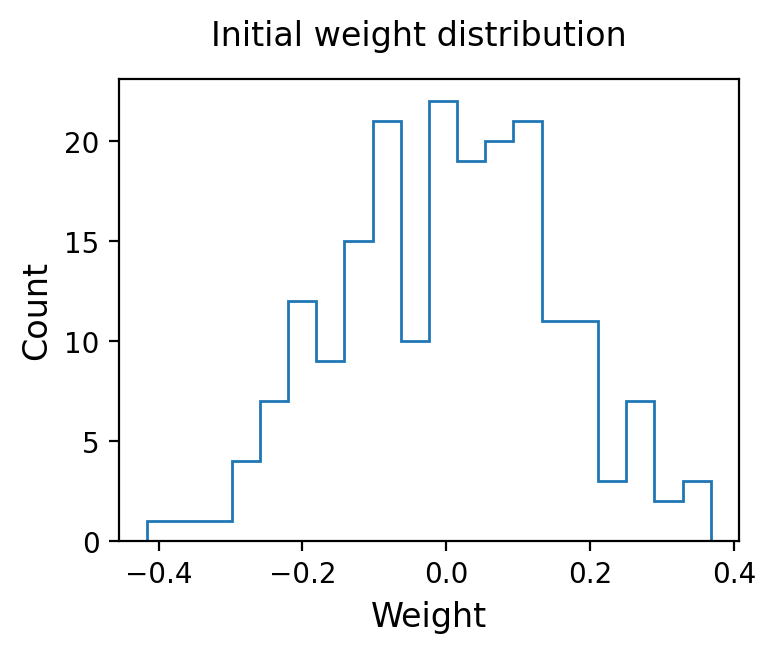

-1.0 0.9843750000000002
[[Array([[-2.51889618e-01,  1.99181817e-01, -1.11711147e-01,
         3.44808777e-02,  1.11737315e-01,  1.67458227e-01,
        -2.37721890e-02, -1.15943927e-01,  1.37917693e-01,
         1.05947055e-01,  1.12868581e-01,  8.06933081e-02,
         8.18021456e-02, -1.50170142e-01, -7.15358175e-02,
        -2.01132804e-01,  5.08088386e-02,  6.00566449e-02,
        -4.12961367e-02,  1.12068545e-02,  3.61890117e-02,
         8.58031641e-02, -1.37126701e-01,  2.01302747e-01,
         6.77133720e-02,  4.55036059e-02,  3.00023395e-01,
        -1.07028556e-01,  6.89212284e-02, -1.68429220e-01,
         3.69311043e-02, -6.52332705e-02,  8.37538189e-03,
         1.46854834e-03, -1.98775793e-01, -8.25953488e-02,
        -6.62556227e-02,  3.10466925e-01, -1.33944209e-01,
         1.46772890e-01,  1.18035374e-01, -2.15562172e-01,
        -4.15877949e-01, -1.87825406e-01, -7.70795767e-02,
        -2.37478186e-01,  1.48431248e-02,  8.21809887e-02,
        -1.76186706e-01,  1.46

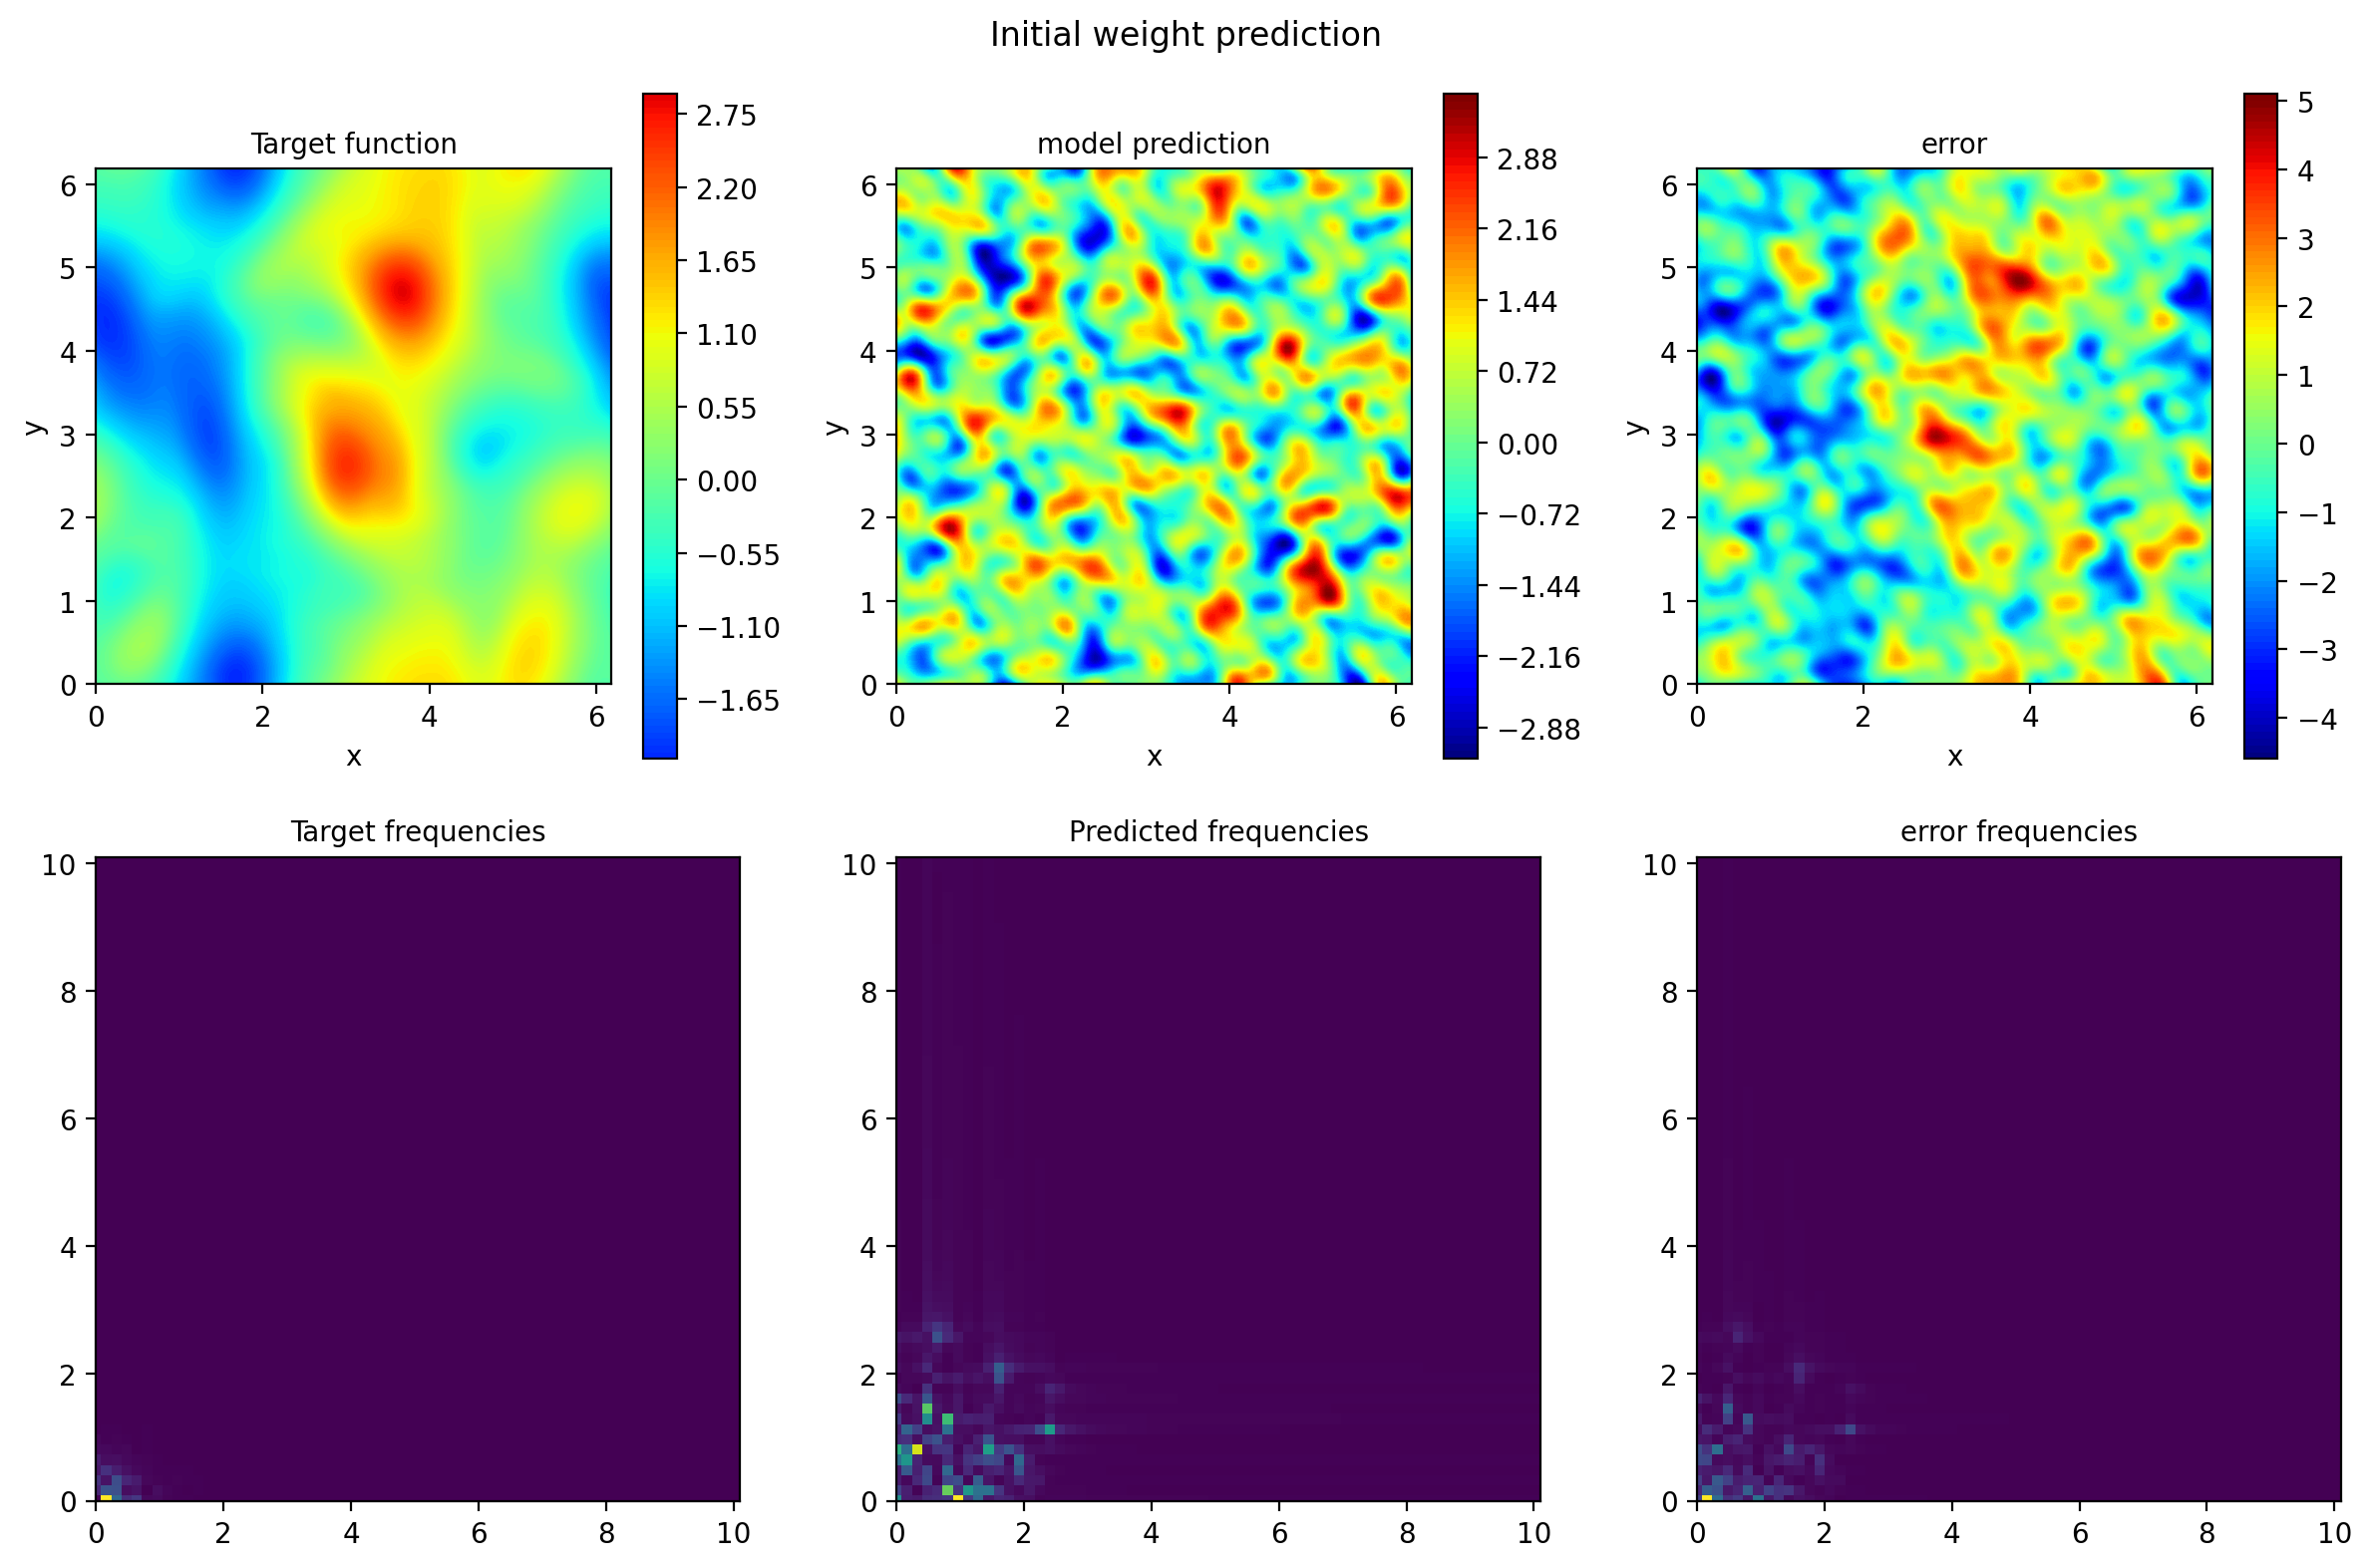

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
[[Traced<ShapedArray(float64[2,100])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[2,100])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[2,100])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[2,100]), None)
    recipe = LambdaBinding(), Traced<ShapedArray(float64[100])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[100])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[100]), None)
    recipe = LambdaBinding()], [Traced<ShapedArray(float64[100,1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[100,1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[100,1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[100,1])

Step: 0 | Loss: 1.0000e+00 | Loss_d: 2.0234e+00 | Loss_e: 0.0000e+00
Step: 10 | Loss: 5.1935e-01 | Loss_d: 1.0508e+00 | Loss_e: 0.0000e+00
Step: 20 | Loss: 4.2093e-01 | Loss_d: 8.5170e-01 | Loss_e: 0.0000e+00
Step: 30 | Loss: 3.6731e-01 | Loss_d: 7.4321e-01 | Loss_e: 0.0000e+00
Step: 40 | Loss: 3.3569e-01 | Loss_d: 6.7923e-01 | Loss_e: 0.0000e+00
Step: 50 | Loss: 3.1680e-01 | Loss_d: 6.4101e-01 | Loss_e: 0.0000e+00
Step: 60 | Loss: 3.0391e-01 | Loss_d: 6.1492e-01 | Loss_e: 0.0000e+00
Step: 70 | Loss: 2.9545e-01 | Loss_d: 5.9780e-01 | Loss_e: 0.0000e+00
Step: 80 | Loss: 2.9012e-01 | Loss_d: 5.8702e-01 | Loss_e: 0.0000e+00
Step: 90 | Loss: 2.8649e-01 | Loss_d: 5.7969e-01 | Loss_e: 0.0000e+00
Step: 100 | Loss: 2.8463e-01 | Loss_d: 5.7591e-01 | Loss_e: 0.0000e+00
Step: 110 | Loss: 2.8224e-01 | Loss_d: 5.7108e-01 | Loss_e: 0.0000e+00
Step: 120 | Loss: 2.8068e-01 | Loss_d: 5.6791e-01 | Loss_e: 0.0000e+00
Step: 130 | Loss: 2.7942e-01 | Loss_d: 5.6538e-01 | Loss_e: 0.0000e+00
Step: 140 | Loss:

-1.0 0.9843750000000002
[[Array([[-0.29392407,  0.20293337, -0.14809013,  0.0267658 ,  0.10378941,
         0.14905884,  0.01672854, -0.1071938 ,  0.14030875,  0.09761127,
         0.11255344,  0.06180143,  0.07206958, -0.13893289, -0.05574099,
        -0.24801446,  0.02910193, -0.02971444, -0.09468913,  0.02502086,
         0.03122411,  0.06656003, -0.17851229,  0.17476966,  0.04738433,
         0.02877185,  0.29531536, -0.07989875,  0.09832849, -0.16093515,
         0.02449681, -0.06097573,  0.02300503, -0.00714638, -0.19830714,
        -0.05712433, -0.06115642,  0.29054734, -0.12401683,  0.14345796,
         0.12058412, -0.231556  , -0.40922649, -0.1428722 , -0.02112966,
        -0.24971224, -0.02450884,  0.09541481, -0.18982698,  0.18665193,
         0.12746348,  0.24030542, -0.02487971, -0.11133049, -0.02616115,
         0.09178608, -0.09007379,  0.18042513, -0.14654238,  0.16142403,
        -0.23826165,  0.11304388,  0.14203049, -0.10081836,  0.34352849,
         0.0269432 , -0.0

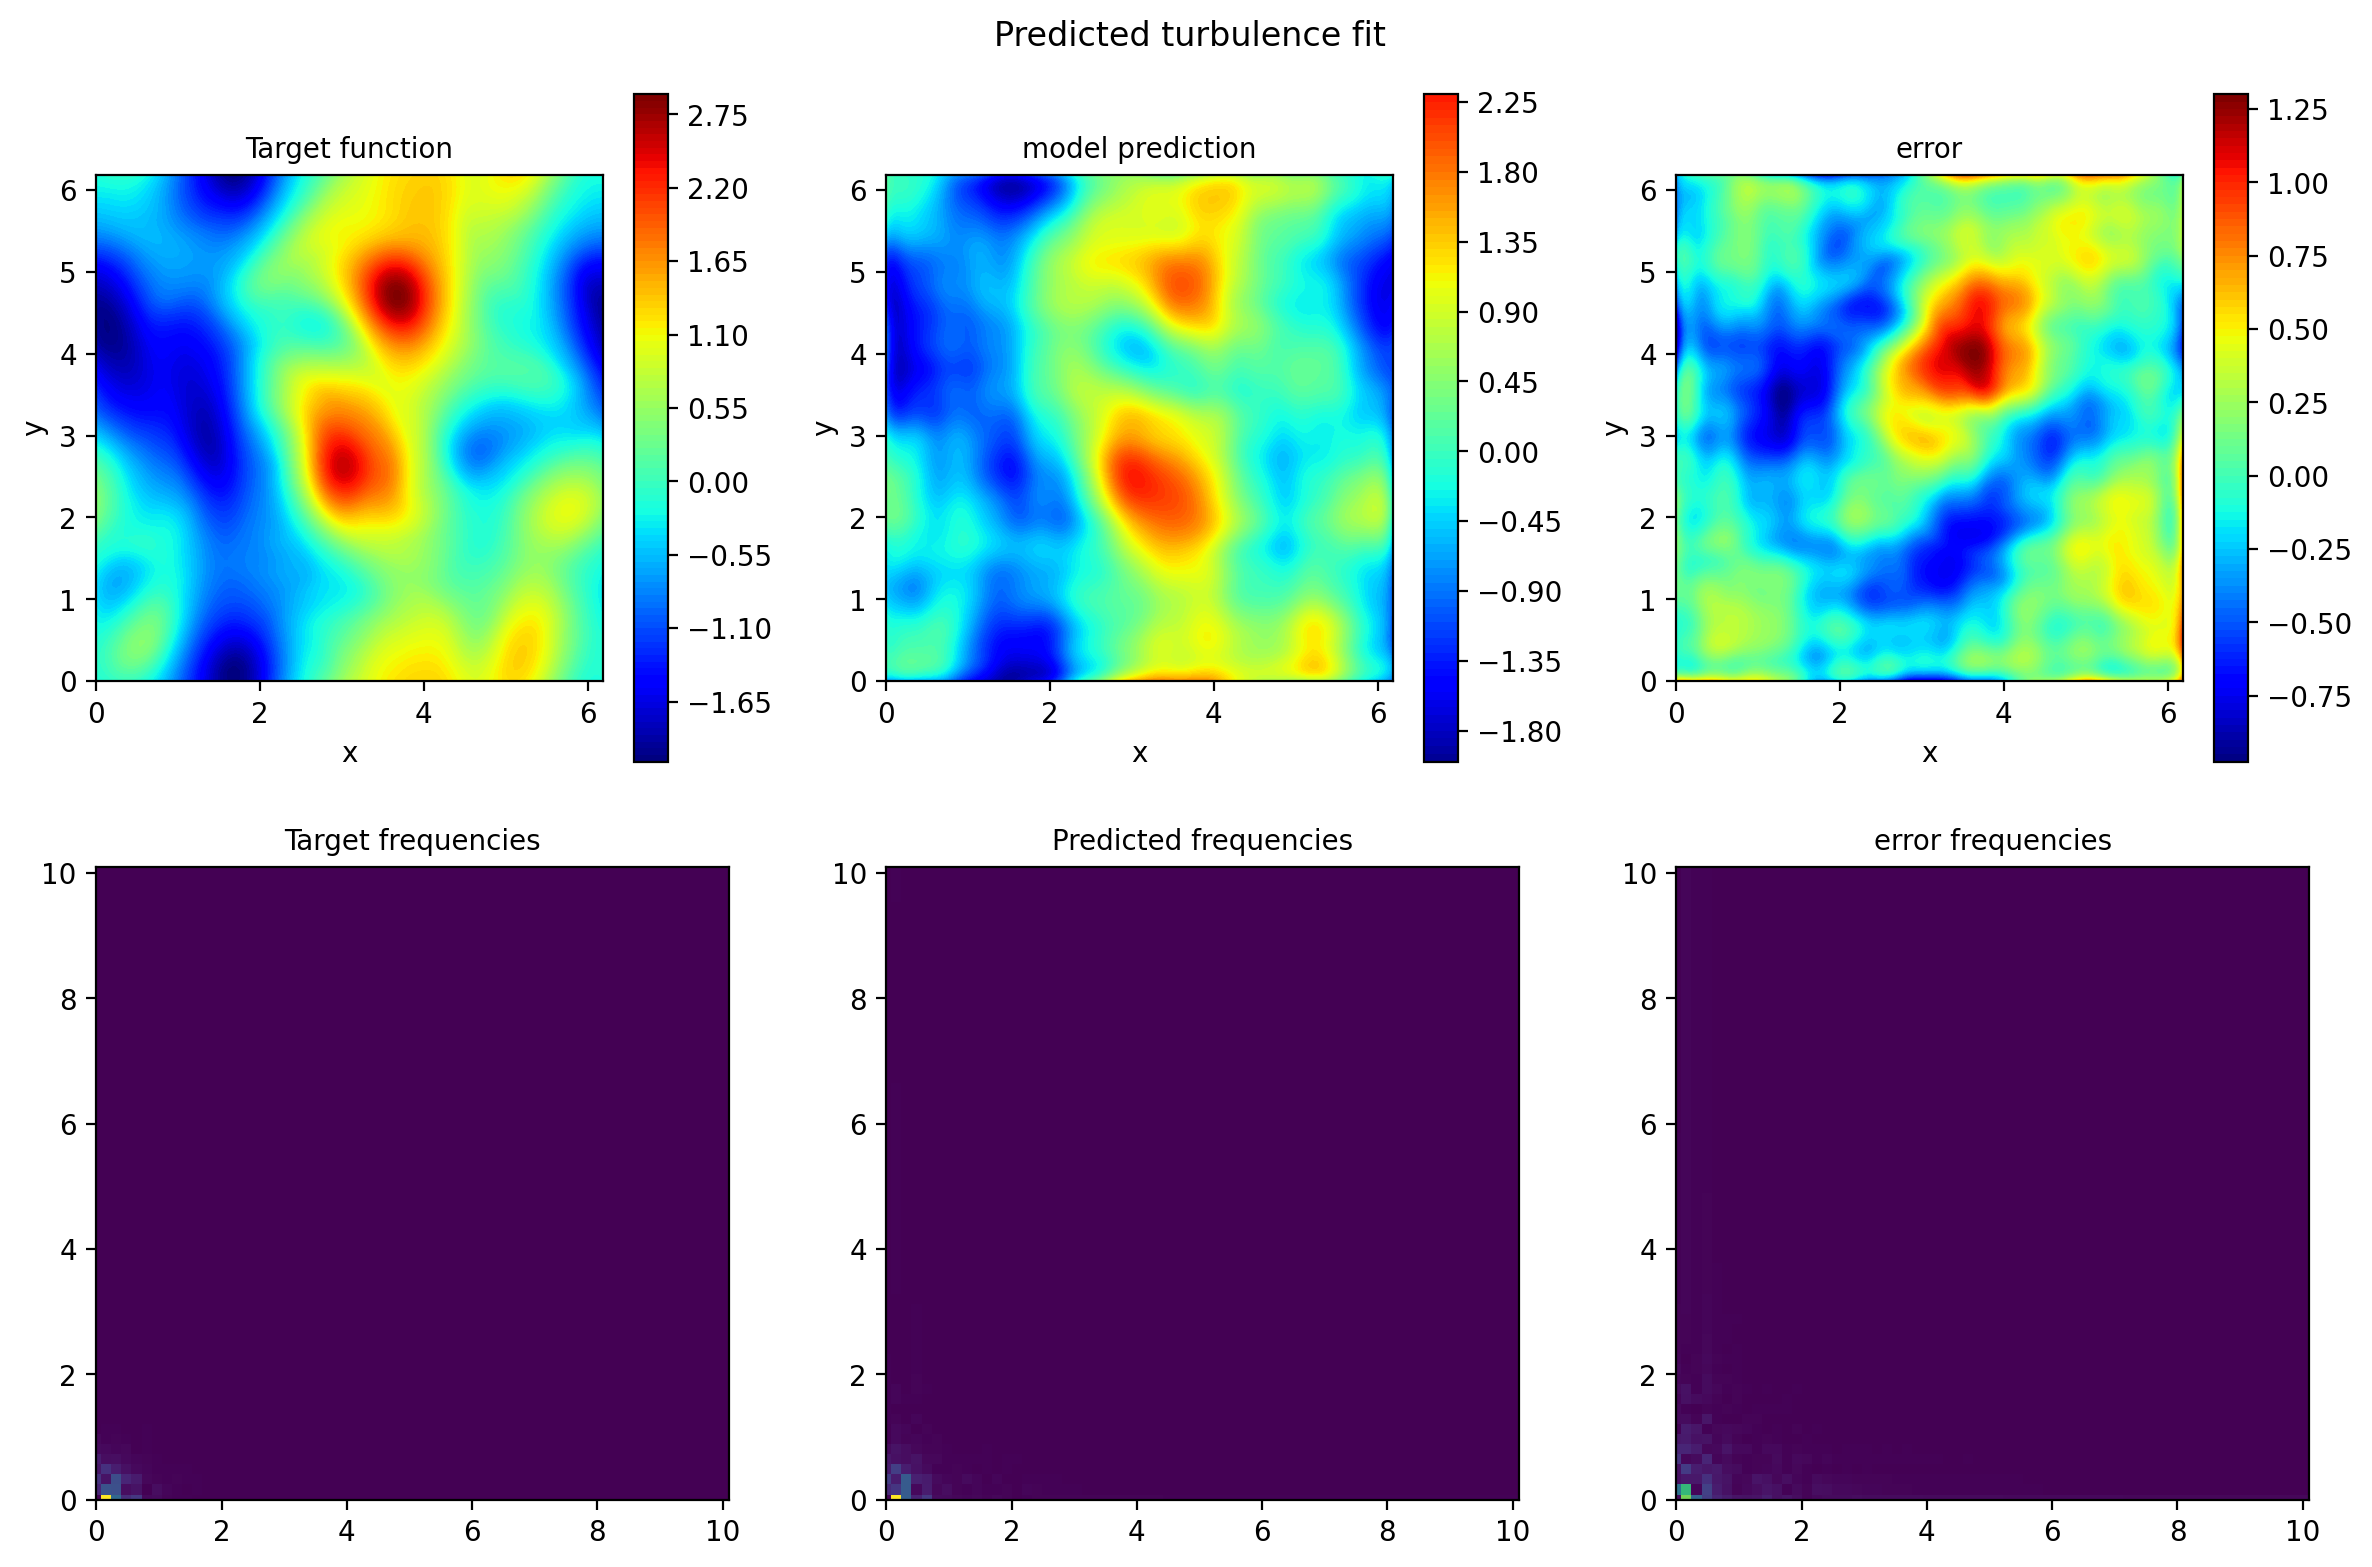

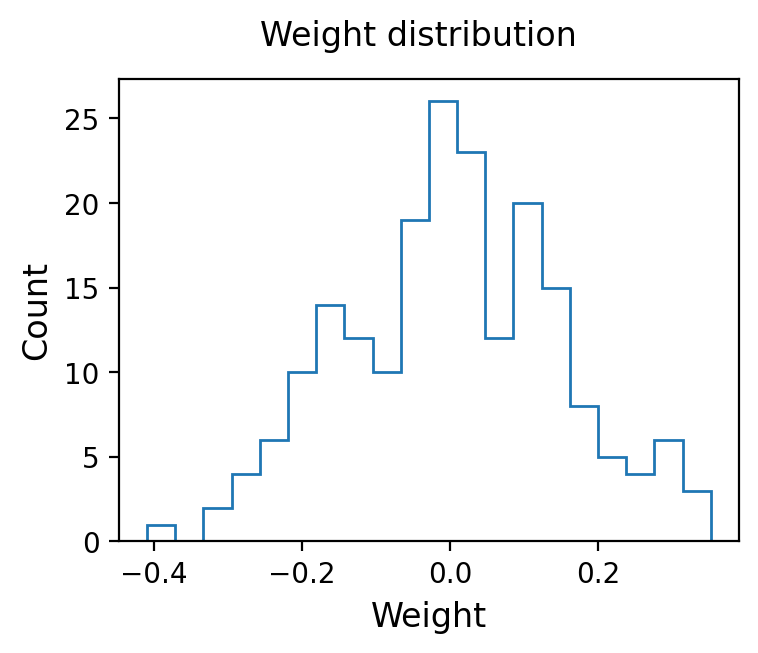

<ipython-input-104-e62f20d67697>:63: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


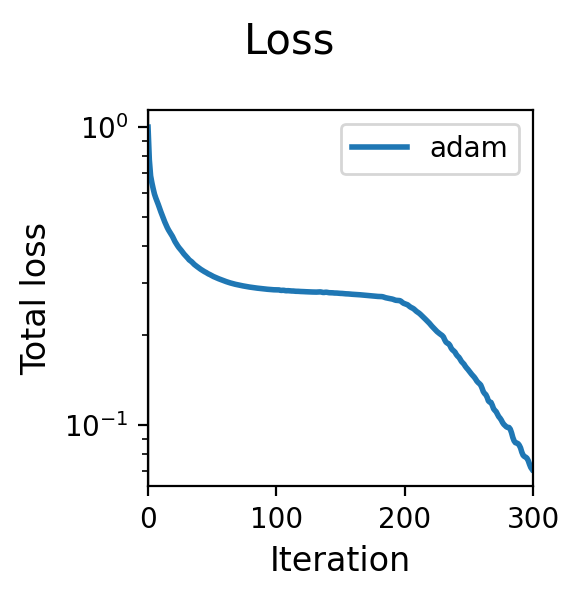

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
[[Traced<ShapedArray(float64[2,100])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[2,100])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[2,100])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[2,100]), None)
    recipe = LambdaBinding(), Traced<ShapedArray(float64[100])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[100])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[100]), None)
    recipe = LambdaBinding()], [Traced<ShapedArray(float64[100,1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[100,1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[100,1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[100,1])

KeyboardInterrupt: 

In [105]:
#@title Run Problem
def init_domain(N_x = 101, N_y = 201, limit = [[0, 0], [1, 1]], endpoint = True):
    '''
    loading the dataset and define the domain
    =============================================
    '''
    lb = limit[0]
    ub = limit[1]
    x = jnp.linspace(lb[0], ub[0], N_x, endpoint = endpoint) #jnp.linspace(0, 1, N_x)
    y = jnp.linspace(lb[1], ub[1], N_y, endpoint = endpoint) #jnp.linspace(-1, 1, N_y)

    X, Y = jnp.meshgrid(x, y)
    X_star = jnp.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Domain bounds

    return X, Y, X_star

# Calculate ideal scale factor from dominant frequency
def calc_scl(f_d = None, in_dim = 1, out_dim = 1):
    if f_d is None:
      return 1
    print(f"{f_d=}")
    scl_hat = 2 * np.pi * f_d # scales with magnitude of the gradient
    V_ar = 2 / (in_dim + out_dim)
    scl = scl_hat / np.sqrt(V_ar)
    print(f"{f_d=}, {scl_hat=}, {scl=}")
    return scl

def calc_f_d(U, N_x, N_y, limit):
    timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
    freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
    freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
    FS = np.fft.fftn(U)
    FS_abs = np.abs(np.fft.fftshift(FS))
    argmax = np.unravel_index(FS_abs.argmax(), FS_abs.shape)
    f_d = np.array([max(freq_x[argmax[1]], 1), max(freq_y[argmax[0]], 1)])
    return f_d

#@title Download Data

def init_turbulence_data(filename = '/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_100k.mat', filetype = "mat", time_index = None):
    if filetype == "mat":
        import h5py
        f = h5py.File(filename,'r')
        print("Keys:")
        for key in f.keys():
            print(key, type(f[key])) # Names of the root level object names in HDF5 file - can be groups or datasets
            # Get the object type: usually group or dataset

        # Get the HDF5 dataset; key needs to be a group name from above
        psi = np.array(f['Psi'][:])
        omega = np.array(f['W'][:])
        N_x = psi.shape[0]
        N_y = psi.shape[1]
        lb = jnp.array([0, 0])
        ub = jnp.array([2 * jnp.pi * (1 - 1 / N_x), 2 * jnp.pi * (1 - 1 / N_x)])
        limit = [lb, ub]
        if time_index is None:
            return psi, omega, limit, N_x, N_y
        else:
            return psi[:, :, time_index], omega[:, :, time_index], limit, N_x, N_y
    elif filetype == "nc":
        import xarray as xr
        ds = xr.open_dataset(filename) #('/home/groups/cyaolai/JakinNg/Fake_Turbulence/fake_turbulence_512_.nc')
        if time_index is None:
            psi = ds.psi
            omega = ds.vorticity
            return psi, omega
        else:
            psi = ds.psi.isel(time = time_index).values
            omega = ds.vorticity.isel(time = time_index).values
            x = ds.x.values
            y = ds.y.values
            lb = jnp.array([jnp.min(x), jnp.min(y)])
            ub = jnp.array([jnp.max(x), jnp.max(y)])
            limit = [lb, ub]
            N_x = x.shape[0]
            N_y = y.shape[0]
            return psi, omega, limit, N_x, N_y

def run_burger_pinn():
    rootdir = Path("/content/drive/MyDrive/Stanford/2024_02_10")
    precision = jnp.float32
    seed = 345

    # Weight for equation loss
    lw = [1e-1]
    # Exponent in loss function
    p = 2
    # neural net layer sizes
    n_hl = 6 # number of hidden layers
    n_unit = 30
    layers = [2] + [100] + (n_hl - 1) * [n_unit] + [1]
    n_iters_train = [200, 200] # number of iterations to train for, approximately
    opt_methods = ["adam", "lbfgs"]

    # scale factor
    scl = 1
    # normalization factor for data magnitude
    epsil = 1
    # activation function
    act_s = 0
    # number of sampling points
    N_col = 10000
    N_bd = 3 # 100
    N_t = 101 # for plotting
    N_x = 102 # for plotting

    '''
    loading the dataset and define the domain
    =============================================
    '''
    lb = jnp.array([0, -1])  # X_star.min(0)
    ub = jnp.array([1, 1])   # X_star.max(0)
    limit = [lb, ub]

    nu = 0.01
    gov_eqn = lambda f_u, x: burger_gov_eqn(f_u, x, nu = nu)

    # Plotter
    plotter = PINN_Plotter(equation = "burger", loss_dict = {}, rootdir = rootdir,
                dpi = 300, precision = precision, fontsize = {'title': 15, 'subtitle': 12}, limit = limit, N_1 = N_t, N_2 = N_x,
                trained_params = None, show = True, gov_eqn = gov_eqn, title = "Predicted Burger's solution", bins = layers[1] // 5,
                           methods = opt_methods)

    for p in [2, 10]:
        plotter.title = "Predicted Burger's solution"
        filename = f'Burgers_2d_basic_nu={nu:.2f}_p={p}'
        trained_params, loss_all, limit, scl, epsil, act_s, act_methods, n_iters = run_pinn(dim = 2, seed = seed, rootdir = Path("/content/drive/MyDrive/Stanford/1_31"), filename = filename,
                precision = jnp.float64, p = p,
                layers = layers, lw = lw, scl = scl, epsil = epsil, act_s = act_s, limit = limit, N_col = N_col, N_bd = N_bd,
                gov_eqn = gov_eqn, sol_pred_create = sol_pred_create, data_func_create = data_func_create_burger,
                plotter = plotter, n_iters_train = n_iters_train, opt_methods = opt_methods)

        mdic = {"params": trained_params['net_u'], "loss_all": loss_all, "limit": limit,
            "scl": scl, "epsil": epsil, "act_s": act_s, "act_methods": act_methods, "n_iters": n_iters, "nu": nu}
        filepath = str(rootdir.joinpath(filename))
        scipy.io.savemat(filepath, mdic)


def run_turbulence_pinn():
    rootdir = Path("/content/drive/MyDrive/Stanford/2024_02_10")
    precision = jnp.float64
    seed = 234
    target = "psi"

    '''
    loading the dataset and define the domain
    =============================================
    '''
    # limit is from [0, 2pi] in both directions
    psi, omega, limit, N_x, N_y = init_turbulence_data(filetype = "mat", time_index = 0)
    gov_eqn = lambda f_u, x: 0

    # Initialize domain and data

    X, Y, X_star = init_domain(N_x = N_x, N_y = N_y, limit = limit, endpoint = False)
    x_train = jnp.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    if target == "psi":
        u_train = psi.reshape(-1, 1)
    elif target == "omega":
        u_train = psi.reshape(-1, 1)
    elif target == "sin_sum":
        f_x = 3
        f_y = 1
        u_train = jnp.sin(f_x * 2 * np.pi * x_train[:, 0:1] + f_y * 2 * np.pi * x_train[:, 1:2])

    # number of sampling points
    N_col = 10000
    N_bd = 3 # 100

    """
    Define initial/boundary conditions and collocation points
    """
    def data_func_create_turbulence(N_col, N_bd, limit):
        # generate the weights for boundary and collocation points
        w_bd = jnp.ones([N_bd*4, 1])
        w_col = jnp.ones([N_col+N_bd*4, 1])
        weight = dict(w_bd=w_bd, w_col=w_col)
        lb = limit[0]
        ub = limit[1]

        # define the target function
        def dataf():
            # prepare the collocation points
            x_col = lhs(2, N_col) * jnp.array([1, 2]) - jnp.array([0, 1])
            # add the collocation at the boundary
            x_col = jnp.vstack([x_col, x_train])

            # group all the conditions and collocation points
            data = dict(z_col=x_col, cond_bd=[x_train, u_train])
            return data
        return dataf, weight

    """ Define neural net parameters """
    # Weight for equation loss
    lw = [0]
    # Exponent in loss function
    p = 2
    # neural net layer sizes
    n_hl = 6 # number of hidden layers
    # n_hl = 0
    n_unit = 30
    # layers = [2] + [30] + (n_hl - 1) * [n_unit] + [1]
    layers = [2] + [100] + [1]
    n_iters_train = [300, 300, 300, 300] # number of iterations to train for, approximately
    opt_methods = ["adam", "lbfgs", "adam", "lbfgs"]

    # scale factor
    if len(layers) >= 2:
        f_d = calc_f_d(U = u_train.reshape(N_y, N_x), N_x = N_x, N_y = N_y, limit = limit)
        scl = calc_scl(f_d = f_d, in_dim = layers[0], out_dim = layers[1])
        # Since the input is rescaled to [-1, 1], rescale scl
        scl = (scl * (limit[1] - limit[0]) / 2).reshape(layers[0], 1)
    else:
        scl = jnp.ones(shape = (layers[0], 1))
    # normalization factor for data magnitude
    epsil = jnp.power(lp2_error(u_train, p = p), 0.5)
    # activation function
    act_s = 1 # sin

    # Plotter
    plotter = PINN_Plotter(equation = "turbulence", loss_dict = {}, rootdir = rootdir,
                dpi = 200, precision = precision, fontsize = {'title': 15, 'subtitle': 12, 'axis': 10}, limit = limit, N_1 = N_x, N_2 = N_y,
                trained_params = None, show = True, gov_eqn = gov_eqn, bins = max(layers[1] // 5, 5),
                           methods = opt_methods)

    dataf, weight = data_func_create_turbulence(N_col, N_bd, limit)
    for p in [2, 10]:
        epsil = jnp.power(lp2_error(u_train, p = p), 0.5)
        print(f"{epsil=}")
        plotter.title = "Predicted turbulence fit"
        filename = f'turbulence_2d_p={p}'
        trained_params, loss_all, limit, scl, epsil, act_s, act_methods, n_iters = run_pinn(dim = 2, seed = seed, rootdir = Path("/content/drive/MyDrive/Stanford/1_31"), filename = filename,
                precision = jnp.float64, p = p,
                layers = layers, lw = lw, scl = scl, epsil = epsil, act_s = act_s, limit = limit, N_col = N_col, N_bd = N_bd,
                gov_eqn = gov_eqn, sol_pred_create = sol_pred_create, data_func_create = data_func_create_turbulence,
                plotter = plotter, n_iters_train = n_iters_train, opt_methods = opt_methods)

        mdic = {"params": trained_params['net_u'], "loss_all": loss_all, "limit": limit,
            "scl": scl, "epsil": epsil, "act_s": act_s, "act_methods": act_methods, "n_iters": n_iters}
        filepath = str(rootdir.joinpath(filename))
        scipy.io.savemat(filepath, mdic)

def energy_spectrum():
    for filename in ["/content/drive/MyDrive/Stanford/FDNS Psi W_val_Forced.mat", "/content/drive/MyDrive/Stanford/FDNS Psi W_val_Re_100k.mat", "/content/drive/MyDrive/Stanford/FDNS Psi W_val_Re_1k.mat",
                     "/content/drive/MyDrive/Stanford/FDNS Psi W_val_nxy_25.mat", "/content/drive/MyDrive/Stanford/FDNS Psi W_val_nxy_4.mat"]:
        print(f"{filename=}")
        # "/content/drive/MyDrive/Stanford/fake_turbulence_512_.nc"
        psi, omega, limit, N_x, N_y = init_turbulence_data(filename = filename, filetype = "mat", time_index = 0)
        precision = jnp.float32
        rootdir = Path("/content/drive/MyDrive/Stanford/1_31")




        # Plotter
        plotter = PINN_Plotter(equation = "turbulence", U = psi, omega = omega, N_1 = N_x, N_2 = N_y, loss_dict = {}, rootdir = rootdir,
                            filename = {"velocities": "velocities.png", "energy_spectrum": f"energy_spectrum.png"},
                    dpi = 300, precision = precision, fontsize = {'title': 15, 'subtitle': 12}, limit = limit,
                    show = True, title = "Energy Spectrum")
        plotter.plot_energy_spectrum()

"""
Entire function to plot energy spectrum (sent to Yongji)
"""
def plot_energy_spectrum():
    time_index = 0
    show = True
    dpi = 300
    filename = '/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_100k.mat'

    import h5py
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import pandas as pd

    # Load data
    f = h5py.File(filename,'r')
    psi = jnp.array(f['Psi'][:])
    omega = jnp.array(f['W'][:])
    if time_index is not None:
        psi = psi[:, :, time_index]
        omega = omega[:, :, time_index]

    # Initialize domain
    N_x = psi.shape[0]
    N_y = psi.shape[1]
    lb = jnp.array([0, 0])
    ub = jnp.array([2 * jnp.pi * (1 - 1 / N_x), 2 * jnp.pi * (1 - 1 / N_x)])
    limit = [lb, ub]

    x = jnp.linspace(lb[0], ub[0], N_x) #jnp.linspace(0, 1, N_x)
    y = jnp.linspace(lb[1], ub[1], N_y) #jnp.linspace(-1, 1, N_y)
    X, Y = jnp.meshgrid(x, y)
    X_star = jnp.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Calculate velocities as derivative of stream function and convert to frequency domain
    gradient = jnp.gradient(psi) #, x, y)
    u = gradient[0] # u = dpsi/dy
    v = -gradient[1] # v = -dpsi/dx
    uv_max = max(jnp.max(u), jnp.max(v), jnp.max(psi))
    uv_min = min(jnp.min(u), jnp.min(v), jnp.min(psi))
    u_hat = jnp.fft.fftn(u, norm = "forward")
    u_hat_abs = jnp.abs(jnp.fft.fftshift(u_hat))
    v_hat = jnp.fft.fftn(v, norm = "forward")
    v_hat_abs = jnp.abs(jnp.fft.fftshift(v_hat))
    timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
    freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
    freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
    velocity_spectrum = jnp.square(u_hat_abs) + jnp.square(v_hat_abs)

    # Plot velocity spectrum
    fig = plt.figure(figsize = [9, 6], dpi = dpi)
    fig.suptitle("Velocity Spectrum", fontsize = 15)

    ax = plt.subplot(231)
    h = ax.pcolormesh(X, Y, psi)
    plt.colorbar(h, ax = ax)
    ax.set_title("$\psi$")
    ax.set_aspect('equal')

    ax = plt.subplot(232)
    h = ax.pcolormesh(X, Y, u)
    plt.colorbar(h, ax = ax)
    ax.set_title("$x$-velocity")
    ax.set_aspect('equal')

    ax = plt.subplot(233)
    plt.colorbar(h, ax = ax)
    h = ax.pcolormesh(X, Y, v)
    ax.set_title("$y$-velocity")
    ax.set_aspect('equal')

    ax = plt.subplot(234)
    plt.colorbar(h, ax = ax)
    h = ax.pcolormesh(X, Y, omega)
    ax.set_title("$\omega$")
    ax.set_aspect('equal')

    ax = plt.subplot(235)
    FS = jnp.fft.fftn(psi, norm = "forward")
    FS = jnp.abs(jnp.fft.fftshift(FS))
    h = ax.pcolormesh(freq_x, freq_y, FS, shading = "auto", norm = colors.LogNorm(vmin=FS.min(), vmax=FS.max()))
    plt.colorbar(h, ax = ax)
    ax.set_title("$\psi$ frequencies")
    ax.set_aspect('equal')

    ax = plt.subplot(236)
    h = ax.pcolormesh(freq_x, freq_y, velocity_spectrum, shading = "auto", norm = colors.LogNorm(vmin=velocity_spectrum.min(), vmax=velocity_spectrum.max()))
    plt.colorbar(h, ax = ax)
    ax.set_title("Velocity spectrum")
    ax.set_aspect('equal')

    plt.tight_layout()

    if show:
        plt.show()
    plt.savefig("velocities.png")

    # Plot energy spectrum
    F_x, F_y = jnp.meshgrid(freq_x, freq_y)
    K = jnp.sqrt(jnp.square(F_x) + jnp.square(F_y))
    # for each index of K, plot K[idx] against velocity_spectrum[idx]
    K = jnp.ravel(K)
    E = jnp.ravel(velocity_spectrum)

    print(f"{E=}, {K=}")
    # Sum over same indices
    df = pd.DataFrame({'E': E, 'K': K})
    round_off = 10
    df.K = df.K.mul(round_off).round().mul(1 / round_off)
    df = df.groupby(['K'])['E'].sum()
    fig = plt.figure(figsize = [4, 3], dpi = dpi)
    fig.suptitle("Energy Spectrum", fontsize = 15)
    ax = plt.subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    df.plot(ax = ax)
    if show:
        plt.show()
    plt.savefig('energy_spectrum')
    plt.close('all')

# find the root directory
def run_pinn(dim, seed, rootdir, filename, precision, p, layers, lw, scl, epsil, act_s, n_iters_train, opt_methods, gov_eqn, sol_pred_create, data_func_create, plotter,
             limit, N_col, N_bd):
    if precision == jnp.float64:
        # change JAX to double precision
        config.update('jax_enable_x64', True)
    elif precision == jnp.float32:
        config.update('jax_enable_x64', True)

    # select the random seed
    key = random.PRNGKey(seed)
    # tf.random.set_seed(seed)
    np.random.seed(seed) # sets random seed for collocation points

    # create the subkeys
    keys = random.split(key, 4)

    # initialize the weights and biases of the network
    trained_params = sol_init_MLP(keys[0], layers = layers)
    plotter.trained_params = trained_params

    # create the solution function
    pred_u = sol_pred_create(limit, scl, epsil=epsil, act_s=act_s)
    plotter.pred_u = pred_u

    # create the data function
    dataf, weights = data_func_create(N_col, N_bd, limit)
    data = dataf()
    plotter.U = data['cond_bd'][1]

    # calculate the loss function, normalized based on initial loss set to 1
    NN_loss = loss_create(pred_u, gov_eqn, lw, loss_ref=1, p = p)
    loss0 = NN_loss(trained_params, data)[0]
    NN_loss = loss_create(pred_u, gov_eqn, lw, loss_ref=loss0, p = p)

    # Plot initialized weight solution, keeping the original title
    plotter.filename = {"loss": f"{filename}_loss.png", "results": f"{filename}_initial_results.png", "weights": f"{filename}_initial_weights.png"}
    plotter_title = plotter.title
    plotter.title = "Initial weight distribution"
    plotter.plot_weights()
    plotter.title = "Initial weight prediction"
    plotter.plot()
    plotter.title = plotter_title

    """Training using Adam"""
    # set the learning rate for Adam
    lr = 5e-3
    # training the neural network
    start_time = time.time()
    # set the training iteration
    n_iters = [] # exact number of iterations trained for each method
    loss_all = []
    for i, n_iter in enumerate(n_iters_train):
        if opt_methods[i] == "adam":
            trained_params, loss = adam_optimizer(NN_loss, trained_params, data, n_iter, lr=lr)
        if opt_methods[i] == "lbfgs":
            trained_params, loss = lbfgs_optimizer(NN_loss, trained_params, data, n_iter)
        loss_all += loss
        n_iters.append(len(loss))
        if lw[0] != 0:
            plotter.loss_dict = {'loss': jnp.array(loss_all)[:, 0], 'loss_d': loss_all[:, 1], 'loss_e': loss_all[:, 2]}
        else:
            plotter.loss_dict = {'loss': jnp.array(loss_all)[:, 0]}
        plotter.filename = {"loss": f"{filename}_{i}_loss.png", "results": f"{filename}_{i}_results.png", "weights": f"{filename}_{i}_weights.png"}
        plotter.trained_params = trained_params
        plotter.n_iters = n_iters
        plotter.plot()
        plotter.title = "Weight distribution"
        plotter.plot_weights()
        plotter.plot_loss()
    loss_all = jnp.array(loss_all)

    # calculate the equation residue
    # f_up = lambda z: pred_u(trained_params, z)

    # calculate the solution
    # u_p = f_up(X_star)
    # f_p = gov_eqn(f_up, X_star, self.nu)

    # U = jnp.reshape(u_p, X.shape)
    # F = jnp.reshape(f_p, X.shape)

    plotter.filename = {"loss": f"{filename}_final_loss.png", "results": f"{filename}_final_results.png", "weights": f"{filename}_final_weights.png"}
    plotter.trained_params = trained_params
    plotter.plot()
    plotter.title = "Final weight distribution"
    plotter.plot_weights()

    if lw[0] != 0:
        plotter.loss_dict = {'loss': loss_all[:, 0], 'loss_d': loss_all[:, 1], 'loss_e': loss_all[:, 2]}
    else:
        plotter.loss_dict = {'loss': loss_all[:, 0]}
    plotter.n_iters = n_iters
    plotter.title = "Loss"
    plotter.plot_loss()
    return trained_params, loss_all, limit, scl, epsil, act_s, opt_methods, n_iters

"""Set the conditions of the problem"""

# run_burger_pinn()
run_turbulence_pinn()
# plot_energy_spectrum()

In [ ]:
######################################################################
############################# Plotting ###############################
######################################################################

rootdir = Path("/content/drive/MyDrive/Stanford/1_31")

for p in [2, 10]:
    FileName = burger_filename(nu = 0.01, p = p)
    FilePath = str(rootdir.joinpath(FileName))
    mdic = scipy.io.loadmat(FilePath)

    pred_u = sol_pred_create(mdic['limit'], mdic['scl'], epsil = mdic['epsil'], act_s = mdic['act_s'].item())

    mdic = scipy.io.loadmat(FilePath)
    loss_dict = {'loss': mdic['loss_all'][:, 0], 'loss_d': mdic['loss_all'][:, 1], 'loss_e': mdic['loss_all'][:, 2]}
    burger_params = {"nu": mdic['nu'].item()}

    precision = jnp.float64
    plotter = PINN_Plotter(loss_dict = loss_dict, rootdir = rootdir, filename = {"loss": f"burger_loss_p{p}.png", "results": f"burger_sol_{p}p.png"},
                           methods = ["adam", "lbfgs"], n_iters = mdic['n_iters'][0], dpi = 300, precision = precision,
                           fontsize = {'title': 15, 'subtitle': 12},
                           trained_params = {'net_u': mdic['params']}, pred_u = pred_u, show = True)
    plotter.plot_loss()
    plotter.plot_burger()

# lb = jnp.array([0, -0.1])  # X_star.min(0)
# ub = jnp.array([1, 0.1])   # X_star.max(0)
# limit = [lb, ub]

In [ ]:
#@title Original Code from Yongji

import sys
import jax.config as config
import jax.numpy as jnp
import numpy as np
import optax
from jax import random, jit, vjp, grad, vmap, pmap
import jax.flatten_util as flat_utl
from jax.experimental.host_callback import call
from tensorflow_probability.substrates import jax as tfp
from pyDOE import lhs
import time
import functools
from scipy.io import savemat
from pathlib import Path

# find the root directory
rootdir = Path("/content/drive/MyDrive/Stanford") #.parent
# change JAX to double precision
config.update('jax_enable_x64', True)


# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s=0):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalizeation [matrx with shape [2, m]]
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var


# define sech function
def sech(z):
    return 1 / jnp.cosh(z)


# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    layers = [2] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return dict(net_u=params_u)


# wrapper to create solution function with given domain size
def sol_pred_create(limit, scl, epsil, act_s=0):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = epsil * neural_net(params['net_u'], z, limit, scl, act_s)
        return u
    return f_u


def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params['net_u'], z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb


"""Low-level functions developed for PINN training using JAX"""

# define the mean squared error
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)


# define the mean squared error with weights
def ms_bias(diff, weight):
    mdiff = 5 * jnp.tanh(0.2*diff) * weight
    return jnp.mean(jnp.square(mdiff), axis=0)


# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol


# governing equation
def gov_eqn(f_u, x, nu=1):
    u_g, u = vectgrad(f_u, x)
    u_t = u_g[:, 0:1]
    u_x = u_g[:, 1:2]

    fu_x = lambda x: vectgrad(f_u, x)[0][:, 1:2]
    # calculate the output and its derivative with original coordinates
    u_xx = vectgrad(fu_x, x)[0][:, 1:2]
    # calculate the residue of the CCF equation
    f = u_t + u*u_x - nu * u_xx
    return f


def gov_deri_eqn(f_u, z, nu):
    # allocate the value to each variable
    fc_res = lambda z: gov_eqn(f_u, z, nu)
    # calculate the residue of higher derivative of CCF equation
    dfunc = lambda z: vectgrad(fc_res, z)[0]
    # calculate the residue of the first and second derivative of CCF equation
    d2f, df = vectgrad(dfunc, z)
    return df, d2f


def loss_create(predf_u, nu, lw, loss_ref):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        # load the data of normalization condition
        z_bd = data['cond_bd'][0]
        u_bd = data['cond_bd'][1]

        # load the position and weight of collocation points
        z_col = data['z_col']

        # calculate the gradient of phi at origin
        u_bd_p = f_u(z_bd)

        # calculate the residue of equation
        f = gov_eqn(f_u, z_col, nu)
        # calculate the residue of first and second derivative
        # df, d2f = gov_deri_eqn(f_u, z_col)

        # calculate the mean squared root error of normalization cond.
        norm_err = ms_error(u_bd_p - u_bd)
        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err])

        # calculate the mean squared root error of equation
        eqn_err_f = ms_error(f)
        # eqn_err_df = ms_error(df)
        # eqn_err_d2f = ms_error(d2f)
        eqn_err = jnp.hstack([eqn_err_f])

        # set the weight for each condition and equation
        data_weight = jnp.array([1.])
        eqn_weight = jnp.array([1.])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err])
        return loss, loss_info
    return loss_fun


def loss_create_lbfgs(loss_f, weights):
    # loss function used for the PINN training
    def loss_fun(params, data):
        loss, loss_info = loss_f(params, weights, data)
        return loss, loss_info
    return loss_fun


# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state


def adam_optimizer(lossf, params, data, epoch, lr=1e-3):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    nc = jnp.int32(jnp.round(epoch / 5))
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if step % 100 == 0:
            print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                  f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[2]:.4e}", file=sys.stderr)
        # saving the loss
        loss_all.append(loss_info[0:3])

        if step % 10000 == 0 and step > 0:
            lr = lr
            opt_Adam = optax.adam(learning_rate=lr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    while llast > lmin:
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        llast = loss_info[0]
        # saving the loss
        loss_all.append(loss_info[0:3])

    return params, loss_all


# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), loss_info[0:3], result_shape=None)
        call(lambda x: print(f"Step: NaN | Loss: {x[0]:.4e} |"
                  f" Loss_d: {x[1]:.4e} | Loss_e: {x[2]:.4e}"), loss_info)
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f


# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3)
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all



def data_func_create(N_col, N_bd, ds):
    # generate the weights for boundary and collocation points
    w_bd = jnp.ones([N_bd*4, 1])
    w_col = jnp.ones([N_col+N_bd*4, 1])
    weight = dict(w_bd=w_bd, w_col=w_col)

    # define the function that can re-sampling for each calling
    def dataf():
        # set the initial and boundary conditions
        tx0 = lhs(2, N_bd) * jnp.array([1, 0]) + jnp.array([0, -1])
        ux0 = 0 * jnp.ones(N_bd)[:, None]

        tx1 = lhs(2, N_bd) * jnp.array([1, 0]) + jnp.array([0, 1])
        ux1 = 0 * jnp.ones(N_bd)[:, None]

        t0x = (2 * lhs(2, 2*N_bd) - 1) * jnp.array([0, 1])
        ut0 = -jnp.sin(np.pi * t0x[:, 1:2])

        # group the initial and boundary conditions
        x_bd = jnp.vstack([tx0, tx1, t0x])
        u_bd = jnp.vstack([ux0, ux1, ut0])

        # prepare the collocation points
        x_col = lhs(2, N_col) * jnp.array([1, 2]) - jnp.array([0, 1])
        # add the collocation at the boundary
        x_col = jnp.vstack([x_col, x_bd])

        # group all the conditions and collocation points
        data = dict(z_col=x_col, cond_bd=[x_bd, u_bd])
        return data
    return dataf, weight


"""Set the conditions of the problem"""

# select the random seed
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 6
n_unit = 30
scl = 1
epsil = 1
nu = 0.01

# number of sampling points
N_col = 10000
N_bd = 100

# set the size of domain
ds = 1.
lmt = jnp.array([[-ds], [ds]])

'''
loading the dataset and define the domain
=============================================
'''
t = jnp.linspace(0, 1, 101)
x = jnp.linspace(-1, 1, 201)

T, X = jnp.meshgrid(t, x)
X_star = jnp.hstack((T.flatten()[:, None], X.flatten()[:, None]))

# Domain bounds
lb = jnp.array([0, -0.1])  # X_star.min(0)
ub = jnp.array([1, 0.1])   # X_star.max(0)
limit = [lb, ub]

# set the training iteration
epoch1 = 10000
epoch2 = 100
lw = [1e-1]

# initialize the weights and biases of the network
trained_params = sol_init_MLP(keys[0], n_hl, n_unit)

# create the solution function
pred_u = sol_pred_create(limit, scl, epsil=epsil, act_s=0)

# create the data function
dataf, weights = data_func_create(N_col, N_bd, ds)
for i in range(10):
    data = dataf()
    print(data['z_col'])

# calculate the loss function
NN_loss = loss_create(pred_u, nu, lw, loss_ref=1)
loss0 = NN_loss(trained_params, data)[0]
NN_loss = loss_create(pred_u, nu, lw, loss_ref=loss0)

"""Training using Adam"""

# set the learning rate for Adam
lr = 5e-3
# training the neural network
start_time = time.time()
trained_params, loss1 = adam_optimizer(NN_loss, trained_params, data, epoch1, lr=lr)
trained_params, loss2 = lbfgs_optimizer(NN_loss, trained_params, data, epoch2)

# calculate the equation residue
f_up = lambda z: pred_u(trained_params, z)

# calculate the solution
u_p = f_up(X_star)
f_p = gov_eqn(f_up, X_star, nu)

U = jnp.reshape(u_p, X.shape)
F = jnp.reshape(f_p, X.shape)

# generate the last loss
loss_all = jnp.array(loss1+loss2)


#%%
import matplotlib.pyplot as plt

######################################################################
############################# Plotting ###############################
######################################################################

mdic = {"params": trained_params, 'T': T, 'X': X, "U": U, "F": F, "loss": loss_all}
FileName = 'Burgers_2d_basic_nu=%.2f.mat' % nu
FilePath = str(rootdir.joinpath(FileName))
savemat(FilePath, mdic)

